# Predicting Lung Cancer Survival.

##### Pooja Patel, Eli Parker, Christopher Wilhite

#### This is the preproccessing data for the train dataset. 

## Importing the Packages. 

Importing matplotlib for visualization and pandas for reading the csv and cleaning.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import re # regular expressions, using this to trim the column names 
import csv
import numpy as np
from lifelines import CoxPHFitter

## Understanding and Visualizing the train data. 

Variables in the Clinical Data. - Pooja

* **Patient Id:** Numbered Patient. 
* **Age:** The age of the Patient. 
* **Histology:** type of cancer cell presented within the patient.
* **Tstage:** determines how much and where the cancer is in the body. The numbers(1-4) describes the tumor size and/or the amount of spread into nearby structures. 0 means there is no evidance of primary tumor.
* **Nstage:** tells weather the cancer has spread to the nearby lymph nodes. The numbers(1-3) describe the size, location, and/or the number of nearby lymph nodes affected by cancer. 0 means nearby lymph nodes do not contain cancer. 
* **Mstage:** tells weather the cancer has spread to distant parts of the body. 0 means no distant cancer has been found. 1 means cancer has been found to have spread to distant organs or tissue. 
* **SourceDataset:**  location where data that is being used originates from

To start the data analysis we read in the clinical data csv and display part of the data. -Eli

In [2]:
df = pd.read_csv('x train(Q0)/clinical_data.csv')
df.head(20)

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
0,202,Adenocarcinoma,0,0,l2,2,66.0000
1,371,large cell,0,2,l1,4,64.5722
2,246,squamous cell carcinoma,0,3,l1,2,66.0452
3,240,nos,0,2,l1,3,59.3566
4,284,squamous cell carcinoma,0,3,l1,4,71.0554
5,348,squamous cell carcinoma,0,2,l1,2,65.0212
6,384,squamous cell carcinoma,0,0,l1,3,78.7105
7,244,Adenocarcinoma,0,0,l2,1,70.0000
8,100,adenocarcinoma,0,0,l1,4,74.4504
9,173,adenocarcinoma,0,2,l1,4,53.0842


The bar graph shows all the different cancer types included in this study against the number of cases that each type had. This graph shows that Adenocarcinoma was the type of cancer with the most recorded cases. This graph also includes the nan and the two types of NOS data that were collected. -Pooja

In [3]:
DeepnoteChart(df, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"Histology","scale":{"type":"linear"}},"y":{"sort":null,"type":"quantitative","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"count","formatType":"numberFormatFromNumberType"},"color":{"sort":null,"type":"nominal","field":"Histology","scale":{"scheme":"tableau10"}}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

First thing with this data frame, we want to see any upfront correlations between the variables, so we will make a matrix. -Can't remember

In [4]:
print(df.corr())

           PatientID    Mstage    Nstage    Tstage       age
PatientID   1.000000 -0.002591 -0.021953 -0.039819 -0.022636
Mstage     -0.002591  1.000000  0.150803  0.176293 -0.056348
Nstage     -0.021953  0.150803  1.000000  0.258406 -0.265379
Tstage     -0.039819  0.176293  0.258406  1.000000 -0.209157
age        -0.022636 -0.056348 -0.265379 -0.209157  1.000000


This matrix here makes no sense, as this suggests that as the age of cancer goes up, the N or T stage goes down. This does not make sense in the context of the progression of cancer.

Variables in the radiomics Data. - Pooja

Radiomics is a method for analyzing high-throughput imaging data and extracting a large number of sophisticated quantitative features. By using radiomics data we can obtain extremely valuable information about cancer that may have been overlooked or that cannot be identified with the naked eye. 

Some information about the 3 main categories that are under radiomics data. 
* shape 
    * describe the shape of the delineated ROI
    * shape descriptors are independent of gray value, and are extracted from the label mask. 
    * If enabled, they are calculated separately of enabled input image types, and listed in the result as if calculated on the original image.
* first order 
    * statistics of the voxel values
* textural 
    * obtained from voxel to neighbouring voxel relationships and provide information on voxel intensities and geometry.
    * grey level co-occurrence matrix (GLCM)
        * quantifies the number of voxels with the same intensities within a given range.
    * Grey-level run-length matrix (GLRLM), 
        * counts the number of consecutive voxels with the same intensity. 
* Some acronyms that are used multiples times in the dataset:
    * ROI: Region of Interest. 
    * GLCM: Gray-Level Co-Occurrence Matrix 
    * GLRLM: Gray Level Run Length Matrix. 

**Below is the description of the varibales in radiomics data** - Pooja

* **shape: original_shape_Compactness1** measure of how compact the shape of the tumor is relative to a sphere (most compact)
* **shape: original_shape_Compactness2** measure of how compact the shape of the tumor is relative to a sphere (most compact)
* **shape: original_shape_Maximum3DDiameter** largest pairwise Euclidean distance between tumor surface mesh vertices.
* **shape: original_shape_SphericalDisproportion** ratio of the surface area of the tumor region to the surface area of a sphere with the same volume as the tumor region, and by definition, the inverse of Sphericity
* **shape: original_shape_Sphericity** measure of the roundness of the shape of the tumor region relative to a sphere
* **shape: original_shape_SurfaceAera** an approximation of the surface of the ROI in mm2, calculated using a marching cubes algorithm.
* **shape: original_shape_SurfaceVolumeRatio** a lower value indicates a more compact (sphere-like) shape. This feature is not dimensionless, and is therefore (partly) dependent on the volume of the ROI.
* **shape: original_shape_VoxelVolume** multiplying the number of voxels in the ROI by the volume of a single voxel
* **firstorder: original_firstorder_Energy** measure of the magnitude of voxel values in an image. A larger values implies a greater sum of the squares of these values.
* **firstorder: original_firstorder_Entropy** specifies the uncertainty/randomness in the image values. It measures the average amount of information required to encode the image values.
* **firstorder: original_firstorder_Kurtosis**   measure of the ‘peakedness’ of the distribution of values in the image ROI. A higher kurtosis implies that the mass of the distribution is concentrated towards the tail(s) rather than towards the mean. A lower kurtosis implies the reverse: that the mass of the distribution is concentrated towards a spike near the Mean value.
* **firstorder: original_firstorder_Maximum** maximum gray level intensity within the ROI.
* **firstorder: original_firstorder_Mean** average gray level intensity within the ROI.
* **firstorder: original_firstorder_MeanAbsoluteDeviation** mean distance of all intensity values from the Mean Value of the image array.
* **firstorder: original_firstorder_Median** median gray level intensity within the ROI.
* **firstorder: original_firstorder_Minimum** minimum gray level intensity within the ROI.
* **firstorder: original_firstorder_Range** range of gray values in the ROI.
* **firstorder: original_firstorder_RootMeanSquared** square-root of the mean of all the squared intensity values. It is another measure of the magnitude of the image values
* **firstorder: original_firstorder_Skewness** measures the asymmetry of the distribution of values about the Mean value. Depending on where the tail is elongated and the mass of the distribution is concentrated, this value can be positive or negative.
* **firstorder: original_firstorder_StandardDeviation** measures the amount of variation or dispersion from the Mean Value.
* **firstorder: original_firstorder_Uniformity** a measure of the sum of the squares of each intensity value. 
* **firstorder: original_firstorder_Variance** the the mean of the squared distances of each intensity value from the Mean value. This is a measure of the spread of the distribution about the mean.
* **textural: original_glcm_Autocorrelation** a measure of the magnitude of the fineness and coarseness of texture.
* **textural: original_glcm_ClusterProminence** a measure of the skewness and asymmetry of the GLCM. A higher values implies more asymmetry about the mean while a lower value indicates a peak near the mean value and less variation about the mean.
* **textural: original_glcm_ClusterShade** measure of the skewness and uniformity of the GLCM. A higher cluster shade implies greater asymmetry about the mean.
* **textural: original_glcm_ClusterTendency** measure of groupings of voxels with similar gray-level values.
* **textural: original_glcm_Contrast** a measure of the local intensity variation, favoring values away from the diagonal (𝑖=𝑗). A larger value correlates with a greater disparity in intensity values among neighboring voxels.
* **textural: original_glcm_Correlation** value between 0 (uncorrelated) and 1 (perfectly correlated) showing the linear dependency of gray level values to their respective voxels in the GLCM.
* **textural: original_glcm_DiffernceEntropy**  measure of the randomness/variability in neighborhood intensity value differences.
* **textural: original_glcm_DifferenceAverage** measures the relationship between occurrences of pairs with similar intensity values and occurrences of pairs with differing intensity values.
* **textural: original_glcm_JointEnergy** Energy is a measure of homogeneous patterns in the image. A greater Energy implies that there are more instances of intensity value pairs in the image that neighbor each other at higher frequencies.
* **textural: original_glcm_JointEntropy** measure of the randomness/variability in neighborhood intensity values.
* **textural: original_glcm_Id** Inverse Difference. Homogeneity 1 is another measure of the local homogeneity of an image.
* **textural: original_glcm_Idm** Inverse Difference Moment. Homogeneity 2 is a measure of the local homogeneity of an image
* **textural: original_glcm_Imc1** Informational Measure of Correlation1. assesses the correlation between the probability distributions of 𝑖 and 𝑗 (quantifying the complexity of the texture)
* **textural: original_glcm_Imc2** Informational Measure of Correlation2. also assesses the correlation between the probability distributions of 𝑖 and 𝑗 (quantifying the complexity of the texture).
* **textural: original_glcm_Idmn** Inverse Difference Moment Normalized. inverse difference moment normalized is a measure of the local homogeneity of an image. 
* **textural: original_glcm_Idn** Inverse Difference Normalized.  inverse difference normalized is another measure of the local homogeneity of an image. normalizes the difference between the neighboring intensity values by dividing over the total number of discrete intensity values.
* **textural: original_glcm_InverseVarience** method of aggregating two or more random varaibles to minimize the variance of the weighted average. 
* **textural: original_glcm_MaximumProbability** occurrences of the most predominant pair of neighboring intensity values.
* **textural: original_glcm_SumAverage** measures the relationship between occurrences of pairs with lower intensity values and occurrences of pairs with higher intensity values.
* **textural: original_glcm_SumEntropy** a sum of neighborhood intensity value differences.
* **textural: original_glrlm_ShortRunEmphasis**  measure of the distribution of short run lengths, with a greater value indicative of shorter run lengths and more fine textural textures.
* **textural: original_glrlm_LongRunEmphasis** measure of the distribution of long run lengths, with a greater value indicative of longer run lengths and more coarse structural textures.
* **textural: original_glrlm_GrayLevelNonUniformity** measures the similarity of gray-level intensity values in the image, where a lower GLN(Gray Level Non-Uniformity) value correlates with a greater similarity in intensity values.
* **textural: original_glrlm_RunLengthNonUniformity** (RLN) measures the similarity of run lengths throughout the image, with a lower value indicating more homogeneity among run lengths in the image.
* **textural: original_glrlm_RunPercentage** (RP) measures the coarseness of the texture by taking the ratio of number of runs and number of voxels in the ROI.
* **textural: original_glrlm_LowGrayLevelRunEmphasis** (LGLRE) measures the distribution of low gray-level values, with a higher value indicating a greater concentration of low gray-level values in the image.
* **textural: original_glrlm_HighGrayLevelRunEmphasis** (HGLRE) measures the distribution of the higher gray-level values, with a higher value indicating a greater concentration of high gray-level values in the image.
* **textural: original_glrlm_ShortRunLowGrayLevelEmphasis** (SRLGLE) measures the joint distribution of shorter run lengths with lower gray-level values.
* **textural: original_glrlm_ShortRunHighGrayLevelEmphasis** (SRHGLE) measures the joint distribution of shorter run lengths with higher gray-level values
* **textural: original_glrlm_LongRunLowGrayLevelEmphasis** (LRLGLRE) measures the joint distribution of long run lengths with lower gray-level values.
* **textural: original_glrlm_LongRunHighGrayLevelEmphasis** (LRHGLRE) measures the joint distribution of long run lengths with higher gray-level values.

Here we are reading in the radiomics csv and displaying part of the data. -Eli?

In [5]:
df2 = pd.read_csv('x train(Q0)/radiomics.csv', header = [0, 2])
df2.head(20)

Unnamed: 0_level_0              shape                     \
            PatientID Unnamed: 1_level_1 Unnamed: 2_level_1   
0                 202           0.027815           0.274892   
1                 371           0.023015           0.188210   
2                 246           0.027348           0.265740   
3                 240           0.026811           0.255406   
4                 284           0.023691           0.199424   
5                 348           0.030981           0.341038   
6                 384           0.028289           0.284341   
7                 244           0.020481           0.149037   
8                 100           0.028028           0.279116   
9                 173           0.018442           0.120841   
10                372           0.031456           0.351557   
11                 83           0.020962           0.156123   
12                423           0.025220           0.225983   
13                197           0.018018           0.115348   
14                149           0.020898           0.155174   
15                394           0.039019           0.540955   
16                185           0.018633           0.123362   
17                316           0.011893           0.050256   
18                225           0.029194           0.302829   
19                102           0.010820           0.041598   

                                                             \
   Unnamed: 3_level_1 Unnamed: 4_level_1 Unnamed: 5_level_1   
0           48.559242           1.537964           0.650210   
1           75.703368           1.744961           0.573079   
2           70.434367           1.555420           0.642913   
3           46.818800           1.576120           0.634469   
4           53.795911           1.711620           0.584242   
5           63.749510           1.431305           0.698663   
6           81.767964           1.520735           0.657577   
7           47.180504           1.886118           0.530189   
8           43.393548           1.530166           0.653524   
9          112.222992           2.022686           0.494392   
10          39.458839           1.416885           0.705774   
11          74.906609           1.857141           0.538462   
12          89.325248           1.641754           0.609105   
13          65.099923           2.054298           0.486784   
14         132.022725           1.860916           0.537370   
15          16.763055           1.227287           0.814805   
16          58.898217           2.008814           0.497806   
17         153.117602           2.709793           0.369032   
18          64.505814           1.489136           0.671530   
19         127.534309           2.886086           0.346490   

                                                             \
   Unnamed: 6_level_1 Unnamed: 7_level_1 Unnamed: 8_level_1   
0         5431.333210           0.275228            19786.0   
1        10369.568729           0.240727            43168.0   
2        10558.818691           0.200766            52655.0   
3         4221.412123           0.323878            13074.0   
4         5295.900331           0.327241            16237.0   
5         8493.134012           0.197602            43036.0   
6        13710.148826           0.170328            80565.0   
7         2391.306856           0.563329             4295.0   
8         3714.449555           0.330283            11286.0   
9        28747.047942           0.180436           159487.0   
10        2941.180179           0.330725             8928.0   
11        5249.507399           0.371479            14209.0   
12       16151.413423           0.176029            91873.0   
13       11734.656758           0.289059            40708.0   
14        1090.579235           0.817500             1364.0   
15         478.783559           0.660809              738.0   
16        6376.235249           0.379187            16937.0   
17       43023.020493           

## Data Wrangling train data. -Eli

Next, we have to process the radiomics.csv into a one-dimensional header. Previously our header was in a three-dimensional shape. To fix this we concatenate the data headers into a one-dimensional header to be used.

In [6]:
# Read in the radiomics CSV file
df2 = pd.read_csv('x train(Q0)/radiomics.csv', header=[0, 1, 2])

# Concatenate the three rows of the header
header = ['_'.join(col).strip() for col in df2.columns.values]

# Update the column names with the concatenated header
df2.columns = header

# Output the modified CSV file
df2.to_csv('x train(Q0)/radiomics_concatenated.csv', index=False)

df2 = df2.rename(columns={df2.columns[0]: 'PatientID'})

regex = r"_Unnamed: \d+_level_2"

# Replace the matched string with an empty string in all column headers
fixed_columns = [re.sub(regex, "", col) for col in df2.columns]

# Update the column headers of the dataframe
df2.columns = fixed_columns

# Output the modified CSV file
df2.to_csv('x train(Q0)/radiomics_concatenated.csv', index=False)

df2.head(10)

,PatientID,shape_original_shape_Compactness1,shape_original_shape_Compactness2,shape_original_shape_Maximum3DDiameter,shape_original_shape_SphericalDisproportion,shape_original_shape_Sphericity,shape_original_shape_SurfaceArea,shape_original_shape_SurfaceVolumeRatio,shape_original_shape_VoxelVolume,firstorder_original_firstorder_Energy,...,textural_original_glrlm_LongRunEmphasis,textural_original_glrlm_GrayLevelNonUniformity,textural_original_glrlm_RunLengthNonUniformity,textural_original_glrlm_RunPercentage,textural_original_glrlm_LowGrayLevelRunEmphasis,textural_original_glrlm_HighGrayLevelRunEmphasis,textural_original_glrlm_ShortRunLowGrayLevelEmphasis,textural_original_glrlm_ShortRunHighGrayLevelEmphasis,textural_original_glrlm_LongRunLowGrayLevelEmphasis,textural_original_glrlm_LongRunHighGrayLevelEmphasis
0,202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
1,371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
2,246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
3,240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
4,284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812
5,348,0.030981,0.341038,63.749510,1.431305,0.698663,8493.134012,0.197602,43036.0,7.938756e+08,...,5.942850,3562.648394,11863.541315,0.567217,0.001557,1066.061196,0.001303,725.085582,0.005632,7256.001857
6,384,0.028289,0.284341,81.767964,1.520735,0.657577,13710.148826,0.170328,80565.0,1.590343e+09,...,6.226823,5527.249509,24798.504928,0.581280,0.001591,906.580156,0.001300,673.971625,0.007185,5904.712840
7,244,0.020481,0.149037,47.180504,1.886118,0.530189,2391.306856,0.563329,4295.0,1.201381e+09,...,1.162536,92.210276,3733.263669,0.952037,0.020421,898.374644,0.019961,853.527412,0.022711,1116.380476
8,100,0.028028,0.279116,43.393548,1.530166,0.653524,3714.449555,0.330283,11286.0,1.341225e+08,...,4.381800,944.952232,3425.645939,0.611936,0.001799,789.530345,0.001441,578.058632,0.006202,3412.686242
9,173,0.018442,0.120841,112.222992,2.022686,0.494392,28747.047942,0.180436,159487.0,1.017260e+09,...,3.373151,22417.882495,59379.643892,0.680075,0.000891,1798.438936,0.000714,1348.581490,0.002425,6138.826557


In this next code block we merge our datasets on the "PatientID" column in order to get one unified data frame.

In [7]:
full_df = pd.merge(df, df2, on=["PatientID"])
print(full_df.shape[0])
full_df.head(20)

300


,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age,shape_original_shape_Compactness1,shape_original_shape_Compactness2,shape_original_shape_Maximum3DDiameter,...,textural_original_glrlm_LongRunEmphasis,textural_original_glrlm_GrayLevelNonUniformity,textural_original_glrlm_RunLengthNonUniformity,textural_original_glrlm_RunPercentage,textural_original_glrlm_LowGrayLevelRunEmphasis,textural_original_glrlm_HighGrayLevelRunEmphasis,textural_original_glrlm_ShortRunLowGrayLevelEmphasis,textural_original_glrlm_ShortRunHighGrayLevelEmphasis,textural_original_glrlm_LongRunLowGrayLevelEmphasis,textural_original_glrlm_LongRunHighGrayLevelEmphasis
0,202,Adenocarcinoma,0,0,l2,2,66.0000,0.027815,0.274892,48.559242,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
1,371,large cell,0,2,l1,4,64.5722,0.023015,0.188210,75.703368,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
2,246,squamous cell carcinoma,0,3,l1,2,66.0452,0.027348,0.265740,70.434367,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
3,240,nos,0,2,l1,3,59.3566,0.026811,0.255406,46.818800,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
4,284,squamous cell carcinoma,0,3,l1,4,71.0554,0.023691,0.199424,53.795911,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812
5,348,squamous cell carcinoma,0,2,l1,2,65.0212,0.030981,0.341038,63.749510,...,5.942850,3562.648394,11863.541315,0.567217,0.001557,1066.061196,0.001303,725.085582,0.005632,7256.001857
6,384,squamous cell carcinoma,0,0,l1,3,78.7105,0.028289,0.284341,81.767964,...,6.226823,5527.249509,24798.504928,0.581280,0.001591,906.580156,0.001300,673.971625,0.007185,5904.712840
7,244,Adenocarcinoma,0,0,l2,1,70.0000,0.020481,0.149037,47.180504,...,1.162536,92.210276,3733.263669,0.952037,0.020421,898.374644,0.019961,853.527412,0.022711,1116.380476
8,100,adenocarcinoma,0,0,l1,4,74.4504,0.028028,0.279116,43.393548,...,4.381800,944.952232,3425.645939,0.611936,0.001799,789.530345,0.001441,578.058632,0.006202,3412.686242
9,173,adenocarcinoma,0,2,l1,4,53.0842,0.018442,0.120841,112.222992,...,3.373151,22417.882495,59379.643892,0.680075,0.000891,1798.438936,0.000714,1348.581490,0.002425,6138.826557


To assure the frames merged correctly, we started by listing the first 300 entries in the data frame

## Cleaning the train data - Eli

After having this, we need to remove rows that have missing values. On top of this, we need to remove rows with Mstage values of 3 and Tstage values of 5. Mstage 3 should be removed due to this being a typo as it only can go from 1-2. Likewise, Tstage 5 should be treated the same as it only moves from 1-4.

In [8]:
full_df = full_df.dropna()
full_df.drop(full_df[full_df['Tstage'] > 4].index, inplace = True)
full_df.drop(full_df[full_df['Mstage'] > 1].index, inplace = True)
full_df.drop(full_df[full_df['Nstage'] > 3].index, inplace = True)
print("Count after dropping missing/incorrect values: " + str(full_df.shape[0]))

Count after dropping missing/incorrect values: 267


At this current moment, PatientID was not needed as it was just taking up space. We remove it from the data frame so that we are solely working with the data needed.

In [9]:
no_PatientID = full_df.drop('PatientID', axis=1)
no_PatientID.describe()

,Mstage,Nstage,Tstage,age,shape_original_shape_Compactness1,shape_original_shape_Compactness2,shape_original_shape_Maximum3DDiameter,shape_original_shape_SphericalDisproportion,shape_original_shape_Sphericity,shape_original_shape_SurfaceArea,...,textural_original_glrlm_LongRunEmphasis,textural_original_glrlm_GrayLevelNonUniformity,textural_original_glrlm_RunLengthNonUniformity,textural_original_glrlm_RunPercentage,textural_original_glrlm_LowGrayLevelRunEmphasis,textural_original_glrlm_HighGrayLevelRunEmphasis,textural_original_glrlm_ShortRunLowGrayLevelEmphasis,textural_original_glrlm_ShortRunHighGrayLevelEmphasis,textural_original_glrlm_LongRunLowGrayLevelEmphasis,textural_original_glrlm_LongRunHighGrayLevelEmphasis
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,...,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,0.007491,0.977528,2.138577,68.898712,0.025842,0.250385,63.654125,1.674659,0.615066,10306.116867,...,2.967885,3883.442333,22129.963363,0.773862,0.005184,1058.456483,0.004609,849.617272,0.010526,3934.741832
std,0.086386,1.159896,1.058216,9.581916,0.006084,0.111655,33.983227,0.314807,0.099066,10901.123996,...,2.290814,6625.440612,30973.498950,0.141074,0.008540,374.070814,0.006861,264.515169,0.026448,3749.990820
min,0.000000,0.000000,1.000000,42.513300,0.009288,0.030648,13.453624,1.154634,0.312946,409.699505,...,1.129743,20.662759,503.361305,0.420690,0.000636,259.345076,0.000401,245.062735,0.001749,325.511805
25%,0.000000,0.000000,1.000000,63.000000,0.021911,0.170580,34.496377,1.455987,0.554590,2281.618619,...,1.353971,182.736516,3712.242293,0.651893,0.001554,791.667386,0.001363,657.958865,0.003581,1362.424311
50%,0.000000,0.000000,2.000000,70.000000,0.025938,0.239045,58.189346,1.611289,0.620621,5720.038227,...,2.105808,916.318954,11206.426294,0.799478,0.002811,1050.667242,0.002546,869.951124,0.004819,2543.171071
75%,0.000000,2.000000,3.000000,76.368250,0.030197,0.323989,83.107630,1.803152,0.686820,14486.470799,...,3.931046,4105.223143,29337.595187,0.907103,0.005206,1338.162381,0.004779,1039.552729,0.007675,5725.430747
max,1.000000,3.000000,4.000000,87.126600,0.042759,0.649631,178.117938,3.195442,0.866075,67799.783468,...,19.569205,38384.558752,267812.272378,0.960043,0.095065,1960.134253,0.069937,1621.293515,0.282310,25570.594397


Here is the count of each value in the 'Histology' column. We can notice that there are 20 NaNs, a bunch of 'nos', and 'NSCLC NOS', which we will assume is the same as 'nos'. Knowing that we have these values, we know that we have to consider what rows we need to remove. 

In [10]:
full_df.Histology.value_counts(sort=False, dropna=False)

squamous cell carcinoma                56
NSCLC NOS (not otherwise specified)     2
adenocarcinoma                         20
large cell                             56
nos                                    34
Adenocarcinoma                         80
Squamous cell carcinoma                19
Name: Histology, dtype: int64

This code block will change the values in the Histology column containing 'NOS' to 'nos'. We had to do this for 2 other Histologies. Now we will only have 4 Histologies. This is something we didn't notice up front but knowing this makes this column easier to digest as the data is able to be confined to rows of the same types of data.

In [11]:
# check which values contain "NOS" (case-insensitive)
mask = full_df['Histology'].str.contains('NOS', case=False, na=False)

# replace values with "nos"
full_df.loc[mask, 'Histology'] = 'nos'

mask = full_df['Histology'].str.contains('Squamous cell carcinoma', case=False, na=False)
full_df.loc[mask, 'Histology'] = 'squamous cell carcinoma'

mask = full_df['Histology'].str.contains('Adenocarcinoma', case=False, na=False)
full_df.loc[mask, 'Histology'] = 'adenocarcinoma'

Here we are remaking the histogram after cleaning out missing or invalid values.

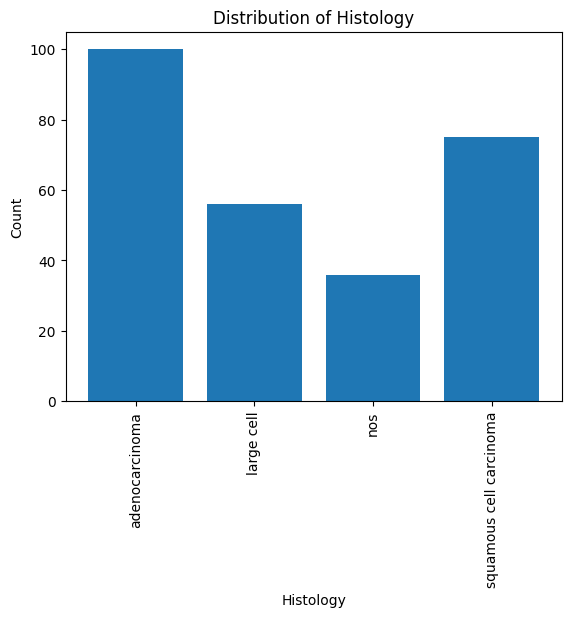

In [12]:
histology_counts = full_df.groupby('Histology').count()

# plot the counts for each histology as a bar chart
plt.bar(histology_counts.index, histology_counts.iloc[:,0])

# set the plot title and axis labels
plt.title('Distribution of Histology')
plt.xlabel('Histology')
plt.ylabel('Count')

plt.xticks(rotation=90)

# show the plot
plt.show()

In [13]:
full_df

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age,shape_original_shape_Compactness1,shape_original_shape_Compactness2,shape_original_shape_Maximum3DDiameter,...,textural_original_glrlm_LongRunEmphasis,textural_original_glrlm_GrayLevelNonUniformity,textural_original_glrlm_RunLengthNonUniformity,textural_original_glrlm_RunPercentage,textural_original_glrlm_LowGrayLevelRunEmphasis,textural_original_glrlm_HighGrayLevelRunEmphasis,textural_original_glrlm_ShortRunLowGrayLevelEmphasis,textural_original_glrlm_ShortRunHighGrayLevelEmphasis,textural_original_glrlm_LongRunLowGrayLevelEmphasis,textural_original_glrlm_LongRunHighGrayLevelEmphasis
0,202,adenocarcinoma,0,0,l2,2,66.0000,0.027815,0.274892,48.559242,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
1,371,large cell,0,2,l1,4,64.5722,0.023015,0.188210,75.703368,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
2,246,squamous cell carcinoma,0,3,l1,2,66.0452,0.027348,0.265740,70.434367,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
3,240,nos,0,2,l1,3,59.3566,0.026811,0.255406,46.818800,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
4,284,squamous cell carcinoma,0,3,l1,4,71.0554,0.023691,0.199424,53.795911,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,89,nos,0,2,l1,4,69.1828,0.026536,0.250187,55.470713,...,1.351356,454.228333,14753.973393,0.907916,0.003964,801.995175,0.003590,740.195978,0.005985,1145.996232
295,261,squamous cell carcinoma,0,0,l1,1,87.1266,0.035752,0.454151,36.619667,...,2.126745,336.573622,6761.904881,0.807157,0.003026,791.295506,0.002829,659.103280,0.004400,2243.689318
297,129,large cell,0,1,l1,3,59.8439,0.025668,0.234096,64.876806,...,7.254939,4513.100699,8467.466888,0.511173,0.001135,1030.197953,0.000784,637.718544,0.006983,7752.599509
298,273,adenocarcinoma,0,0,l2,1,70.0000,0.032517,0.375695,22.472205,...,1.231149,40.140124,1137.721790,0.934473,0.013537,525.682829,0.012984,486.598834,0.016086,726.945564


We can see here that adenocarcinoma and squamous cell carcinoma are the most represented histologies in our data. This could potentially yield a bias in the data, so we can try to separate the data into these four types.

I made a pair plot using seaborn to condense some correlations down but also visualize them.

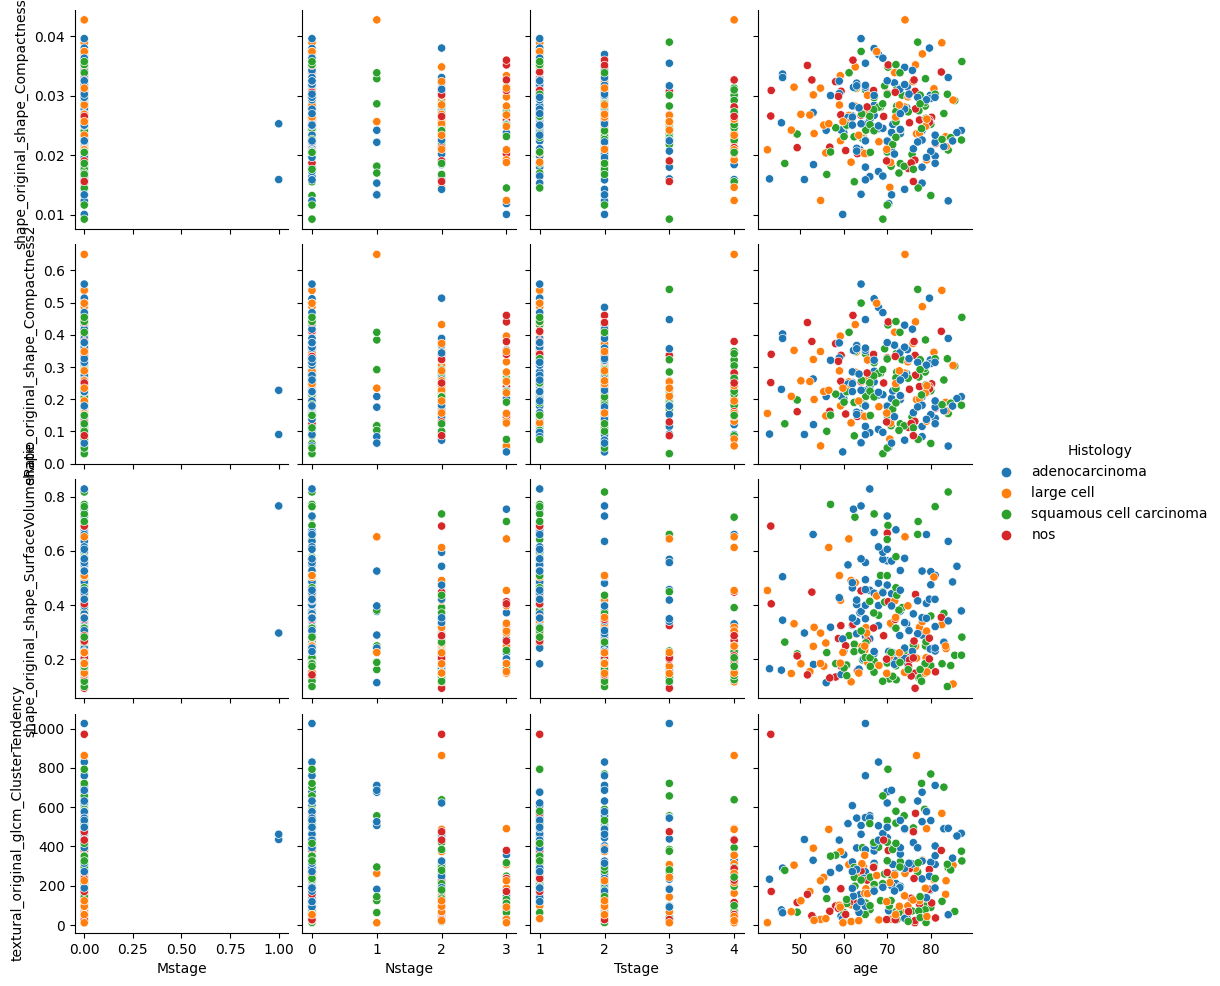

In [14]:
pairplot_cols = full_df[['Histology', 'Mstage', 'Nstage', 'Tstage', 'age', 'shape_original_shape_Compactness1', 'shape_original_shape_Compactness2', 'shape_original_shape_SurfaceVolumeRatio', 'textural_original_glcm_ClusterTendency']]
sb.pairplot(pairplot_cols, x_vars=['Mstage', 'Nstage', 'Tstage', 'age'], y_vars=['shape_original_shape_Compactness1', 'shape_original_shape_Compactness2', 'shape_original_shape_SurfaceVolumeRatio', 'textural_original_glcm_ClusterTendency'], hue='Histology')
plt.show()

Here are the variables in this plot:

- On the x-axis we have Mstage, Nstage, Tstage, and age.

- On the y-axis, we have shape_original_shape_Compactness1, shape_original_shape_Compactnesss2, shape_original_shape_SurfaceVolumeRatio, and textural_original_glcm_ClusterTendency.

What we notice from these plots is that the values compared with the different stage categorical variables are all over the place, being that the stage variables don't have many variables to compare to. We can say the same about age but looking at where all the points in the cluster areas lie, we can potentially see a positive correlation if we were to implement a line of best fit. I will do this in the next step.

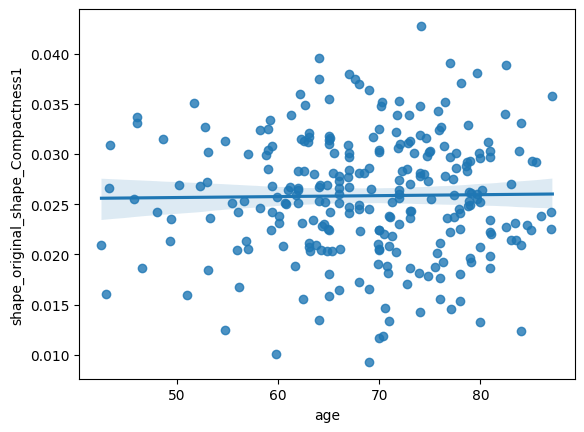

In [15]:
sb.regplot(x=full_df[['age']], y=full_df[['shape_original_shape_Compactness1']], data=full_df);

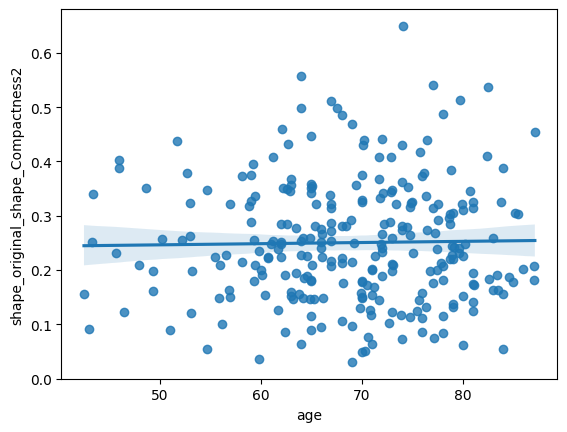

In [16]:
sb.regplot(x=full_df[['age']], y=full_df[['shape_original_shape_Compactness2']], data=full_df);

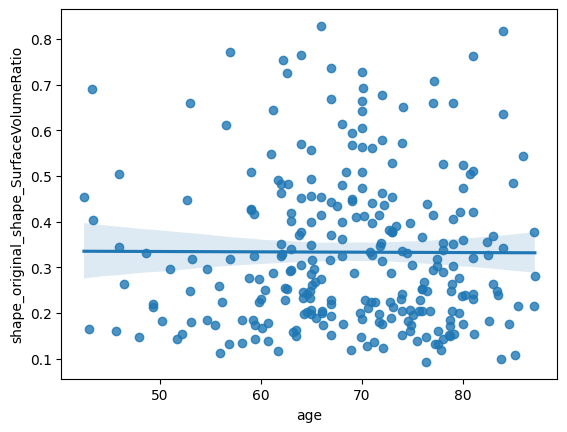

In [17]:
sb.regplot(x=full_df[['age']], y=full_df[['shape_original_shape_SurfaceVolumeRatio']], data=full_df);

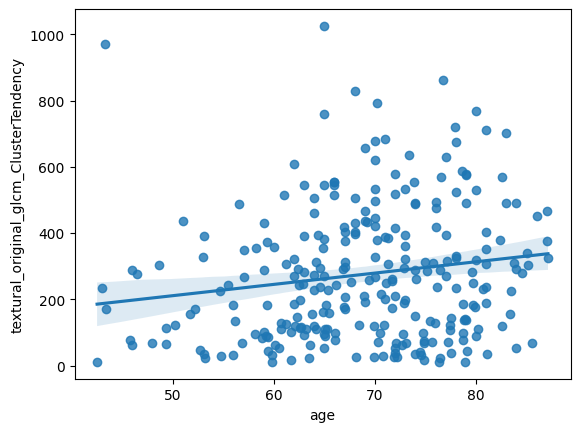

In [18]:
sb.regplot(x=full_df[['age']], y=full_df[['textural_original_glcm_ClusterTendency']], data=full_df);

The first three scatterplots have a flat line of best fit, meanwhile, the plot of age vs cluster tendency shows a slightly positive correlation. From this we can just gather that as the age of the cancer patient goes up, the cluster tendency may become more prevalent.

Here we just dropped columns that we do not need for predicting numeric values.

In [19]:
full_df = full_df.drop(['Histology','SourceDataset'], axis=1)
full_df.head(10)

,PatientID,Mstage,Nstage,Tstage,age,shape_original_shape_Compactness1,shape_original_shape_Compactness2,shape_original_shape_Maximum3DDiameter,shape_original_shape_SphericalDisproportion,shape_original_shape_Sphericity,...,textural_original_glrlm_LongRunEmphasis,textural_original_glrlm_GrayLevelNonUniformity,textural_original_glrlm_RunLengthNonUniformity,textural_original_glrlm_RunPercentage,textural_original_glrlm_LowGrayLevelRunEmphasis,textural_original_glrlm_HighGrayLevelRunEmphasis,textural_original_glrlm_ShortRunLowGrayLevelEmphasis,textural_original_glrlm_ShortRunHighGrayLevelEmphasis,textural_original_glrlm_LongRunLowGrayLevelEmphasis,textural_original_glrlm_LongRunHighGrayLevelEmphasis
0,202,0,0,2,66.0000,0.027815,0.274892,48.559242,1.537964,0.650210,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
1,371,0,2,4,64.5722,0.023015,0.188210,75.703368,1.744961,0.573079,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
2,246,0,3,2,66.0452,0.027348,0.265740,70.434367,1.555420,0.642913,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
3,240,0,2,3,59.3566,0.026811,0.255406,46.818800,1.576120,0.634469,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
4,284,0,3,4,71.0554,0.023691,0.199424,53.795911,1.711620,0.584242,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812
5,348,0,2,2,65.0212,0.030981,0.341038,63.749510,1.431305,0.698663,...,5.942850,3562.648394,11863.541315,0.567217,0.001557,1066.061196,0.001303,725.085582,0.005632,7256.001857
6,384,0,0,3,78.7105,0.028289,0.284341,81.767964,1.520735,0.657577,...,6.226823,5527.249509,24798.504928,0.581280,0.001591,906.580156,0.001300,673.971625,0.007185,5904.712840
7,244,0,0,1,70.0000,0.020481,0.149037,47.180504,1.886118,0.530189,...,1.162536,92.210276,3733.263669,0.952037,0.020421,898.374644,0.019961,853.527412,0.022711,1116.380476
8,100,0,0,4,74.4504,0.028028,0.279116,43.393548,1.530166,0.653524,...,4.381800,944.952232,3425.645939,0.611936,0.001799,789.530345,0.001441,578.058632,0.006202,3412.686242
9,173,0,2,4,53.0842,0.018442,0.120841,112.222992,2.022686,0.494392,...,3.373151,22417.882495,59379.643892,0.680075,0.000891,1798.438936,0.000714,1348.581490,0.002425,6138.826557


In [20]:
full_df.to_csv('x train(Q0)/train_full_df.csv', index=False)

Below here, we have attempted 3 different regression models: Random Forest, Linear, and Cox. We decided to go for regression models because we are predicting values and not classifying. 

## Models

### Random Forest Regression - Christopher

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import random

# our two dataframes for X and y splits
y_csv = pd.read_csv('ytrain.csv')
merged_df = pd.merge(full_df, y_csv, on='PatientID')

# separating features
X = merged_df.drop('SurvivalTime', axis=1)
y = merged_df['SurvivalTime']

# splits the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# feature scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [60],
    'min_samples_split': [15],
    'min_samples_leaf': [5]
}

rfe = RandomForestRegressor()
rfe.fit(X_train, y_train)

importances = rfe.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

top_features = X.columns[indices][:20]

X_train = X_train[top_features]
X_test = X_test[top_features]

grid_search = GridSearchCV(estimator=rfe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_rfe = grid_search.best_estimator_
print(best_rfe)

y_pred = best_rfe.predict(X_test)
print('Predicted Values: ')
y_pred = np.maximum(y_pred, 0) # changing negative values 
np.set_printoptions(suppress=True, precision=0)
print(y_pred)

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

r2_score(y_test, y_pred)
best_rfe.score(X_test, y_test)


Feature ranking:
1. feature 58 (0.284684)
2. feature 40 (0.049301)
3. feature 39 (0.048777)
4. feature 41 (0.043883)
5. feature 10 (0.034985)
6. feature 42 (0.032079)
7. feature 12 (0.025764)
8. feature 7 (0.024910)
9. feature 32 (0.024882)
10. feature 57 (0.022816)
11. feature 54 (0.022681)
12. feature 21 (0.020396)
13. feature 52 (0.019036)
14. feature 4 (0.017845)
15. feature 45 (0.016168)
16. feature 13 (0.014565)
17. feature 20 (0.014112)
18. feature 56 (0.014055)
19. feature 11 (0.013967)
20. feature 55 (0.013530)
21. feature 2 (0.012676)
22. feature 29 (0.012627)
23. feature 44 (0.010732)
24. feature 28 (0.010197)
25. feature 53 (0.009865)
26. feature 31 (0.009787)
27. feature 16 (0.009679)
28. feature 0 (0.009467)
29. feature 43 (0.009063)
30. feature 27 (0.009059)
31. feature 6 (0.009010)
32. feature 9 (0.007215)
33. feature 50 (0.006699)
34. feature 22 (0.006661)
35. feature 8 (0.006223)
36. feature 37 (0.006216)
37. feature 51 (0.006039)
38. feature 35 (0.006021)
39. feature

0.3616518412086114

Brief explanation of the above code:

The code begins by reading in two CSV files named 'radiomics_concatenated.csv' and 'ytrain.csv' using pandas.read_csv. The first CSV file contains radiological features, while the second CSV file contains the survival times of patients. The two datasets are then merged into a single DataFrame named 'merged_df' using the pandas.merge method based on a common column 'PatientID'.

Next, the features (all columns except 'SurvivalTime') and target variable ('SurvivalTime') are separated into two separate DataFrames named 'X' and 'y', respectively, using the pandas.DataFrame.drop method.

The data is then split into training and testing sets using the train_test_split function from the sklearn.model_selection module. The training set contains 80% of the data, while the testing set contains the remaining 20%. The random_state parameter is set to 42 for reproducibility.

A random forest regression model is then created using the RandomForestRegressor class from the sklearn.ensemble module. The fit method is called on the training data to train the model.

The trained model is used to make predictions on the testing set, and the predicted values are stored in 'y_pred'. The R-squared value between the actual target values and the predicted values is calculated using the r2_score function from the sklearn.metrics module, which measures the proportion of variance in the target variable that is explained by the predictor variables.

Finally, the predicted values are printed to the console, followed by the R-squared value. This code performs the task of training a random forest regression model to predict survival times of patients with glioblastoma based on radiological and clinical features.

Random Forest Scatterplot

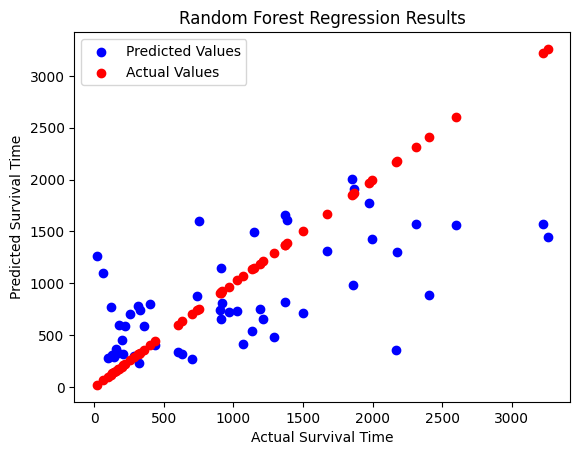

In [22]:

y_test_small = y_test[:81]
y_pred_noneg_small = y_pred[:81]

fig, ax = plt.subplots()
ax.scatter(y_test_small, y_pred_noneg_small, c='b', label='Predicted Values')
ax.scatter(y_test_small, y_test_small, c='r', label='Actual Values')
ax.set_xlabel('Actual Survival Time')
ax.set_ylabel('Predicted Survival Time')
ax.set_title('Random Forest Regression Results')
ax.legend()
plt.show()

### Linear Regression Model - Eli

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

y_csv = pd.read_csv('ytrain.csv')
merged_df = pd.merge(full_df, y_csv, on='PatientID')

X = merged_df.drop('SurvivalTime', axis=1)
y = merged_df['SurvivalTime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# feature scaling
scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

# model
model = LinearRegression()
model.fit(X_train, y_train)

print('Predicted Values: ')
y_pred = model.predict(X_train)
y_pred = np.maximum(y_pred, 0)
np.set_printoptions(suppress=True, precision=0)
print(y_pred)

r2_score(y_train, y_pred)
model.score(X_test, y_test)

# mse = mean_squared_error(y_test, y_pred)
# print("Mean squared error:", mse)

Predicted Values: 
[ 412.  972.  807. 1380. 1351.  613.  820. 1338.  694.    0. 1273.  311.
  328. 1159.  527. 2214.  716. 1024. 1505. 1095. 1137. 1023. 1208.  305.
  821.    0.  448. 1020. 1461. 1451.  228. 1402.  149.  541.  759.  433.
 1301.  537.  990.  687. 1757.  631. 1485. 1365. 1448.  960.  611.  639.
  270.   37.  679.  631.  543.  998.  136.  736. 1917.  878.  275.  448.
  758.  897. 1841.  626.  400.  671.  275. 1454.  148. 1402.  137.  373.
  972.  208. 1930.  541. 1497.  863. 1238.  871.  686. 2269.  595.  546.
  975.  280. 1590. 1186.  397. 1709. 1222.  702. 1255.  169.  984. 1003.
 1707. 1182.  634.  993. 1072. 1138.  776. 1453.  132. 1836.  358.  617.
    0. 1537.  651.  434.  194.  368.  429. 1092.  446.  372.  260. 1649.
  162.  245.    0. 1530. 1678. 1136. 1185. 1420. 1309.  972.  295.  377.
  729.  295.   74. 1122. 1845.  689.  278.  222.  423.  675.    0.  638.
 1474. 1316.  759. 1309.  664.  660.  882. 1522.  283.  669. 1724. 1575.
  799.  495.  784.  462.  810. 1

0.15226204203218363

Here I implemented a linear regression model with feature elimination and scaling.

I noticed that if you lower the number of selected features, the r-squared score becomes significantly lower, so I am just keeping that set to 55.

I tried to implement mix/max scaling but it seemed to make the model's r-squared score lower than with the StandardScaler function. 

The naive linear regression model here acquires an r-squared score around the 50-59% range, which means the model would need more work in able to better predict the survival times. 

Below is an actual plot of the linear regression.

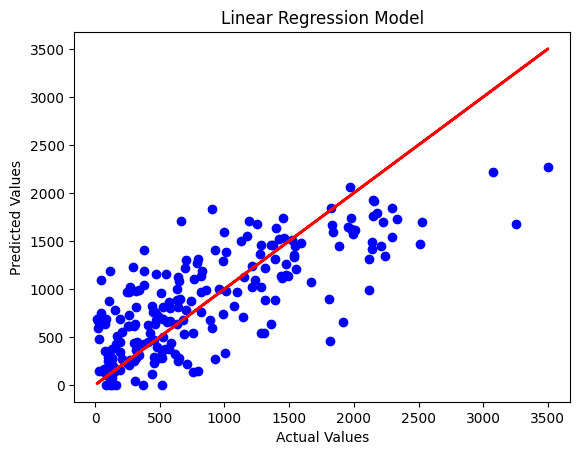

In [24]:
import matplotlib.pyplot as plt

plt.scatter(y_train, y_pred, color='blue')
plt.plot(y_train, y_train, color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression Model')
plt.show()

### Kaplan Meier - Pooja

Kaplan-Meier analysis focuses on estimating the survival function, which represents the probability of survival as a function of time. The accuracy of the Kaplan-Meier estimator is determined by how well it fits the observed data and is typically evaluated using statistical tests such as the log-rank test or the Wilcoxon test. These tests compare the observed survival curve to the expected survival curve under the null hypothesis of no difference between groups and can be used to assess whether there are significant differences in survival between different groups or subpopulations.

If the p-value is above the significance level=, you can reject the null hypothesis and conclude that there is a significant difference in survival between the groups. If the p-value is below the significance level, you cannot reject the null hypothesis and conclude that there is no significant difference in survival between the groups.

Confidence Interval for dataset 1: 
        KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0                   1.000000                1.000000
14.0                  0.947832                0.998937
20.0                  0.947832                0.998937
21.0                  0.947832                0.998937
33.0                  0.940768                0.996189
...                        ...                     ...
2309.0                0.263507                0.554256
2330.0                0.263507                0.554256
2600.0                0.263507                0.554256
3078.0                0.263507                0.554256
3500.0                0.263507                0.554256

[129 rows x 2 columns]
Confidence Interval for dataset 2: 
        KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0                   1.000000                1.000000
25.0                  0.948212                0.998945
31.0                  0.941643                0.996246
43.0                  0.

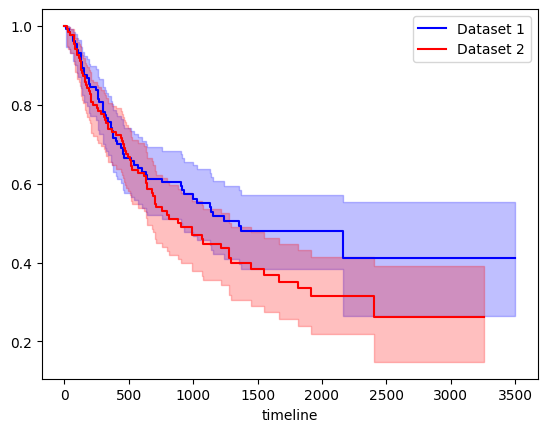

In [25]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.model_selection import train_test_split


# Load the clinical data, features data, and survival data into separate dataframes

survival_data_train = pd.read_csv('ytrain.csv')
train_full_data = pd.read_csv('x train(Q0)/train_full_df.csv')


# Merge the dataframes based on a common identifier column
merged_data = pd.merge(train_full_data, survival_data_train, on='PatientID')
train_data1, train_data2 = train_test_split(merged_data, test_size=0.5, random_state=40)
#print(merged_data.dtypes)
#print(merged_data)
#print(train_data1)
#print(train_data2)

# Extract the relevant columns for analysis
time_column = 'SurvivalTime'  # column containing the time-to-event data
event_column = 'Event'  # column containing the event indicator data


# columns containing the covariate data (excluding string columns)
#feature_columns = [col for col in merged_data.columns if col not in [time_column, event_column] and merged_data[col].dtype != 'O']  
#test_feature_columns = [col for col in test_merged_data.columns if col not in [time_column, event_column] and test_merged_data[col].dtype != 'O']  

# Create a Kaplan-Meier estimator object and fit the survival data
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

kmf1.fit(train_data1[time_column], event_observed=train_data1[event_column])
kmf2.fit(train_data2[time_column], event_observed=train_data2[event_column])


# Plot the survival curve
kmf1.plot(color='blue', label='Dataset 1')
kmf2.plot(color='red', label='Dataset 2')

confidence_interval1 = kmf1.confidence_interval_
survival_function1 = kmf1.survival_function_
event_table1 = kmf1.event_table

confidence_interval2 = kmf2.confidence_interval_
survival_function2 = kmf2.survival_function_
event_table2 = kmf2.event_table

# # print confident Interval
print('Confidence Interval for dataset 1: ')
print(confidence_interval1)

print('Confidence Interval for dataset 2: ')
print(confidence_interval2)

# # print the survival function
print('Survival function for dataset 1:')
print(survival_function1)

print('Survival function for dataset 2:')
print(survival_function2)

# # print the event table
print('Event table for dataset 1 :')
print(event_table1)

print('Event table for dataset 2 :')
print(event_table2)

results = logrank_test(train_data1[time_column], train_data2[time_column],train_data1[event_column], train_data2[event_column])

# print the results
print('Log-rank test results:')
print(results.summary)
print('p-value: {:.3f}'.format(results.p_value))
print('test statistic: {:.3f}'.format(results.test_statistic))


This code uses the Kaplan-Meier estimator from the lifelines package to analyze survival data. It starts by loading the survival data and feature data into separate data frames and merging them based on a common identifier column. Then, it splits the merged data into two random subsets for training purposes. The relevant columns for analysis are extracted, including the time-to-event data, event indicator data, and covariate data.

Two Kaplan-Meier estimator objects are created and trained on each of the training subsets. The survival curves for each dataset are plotted, and the confidence intervals, survival functions, and event tables are printed for Dataset 1. The same information is also calculated for dataset 2, but only the confidence interval is printed. Finally, a log-rank test is performed to compare the survival distributions of the two datasets. 

The results of the log-rank test are printed, including the summary, p-value, and test statistic. The p-value provides evidence for or against the null hypothesis that the survival curves for the two datasets are the same.

Overall, this code provides a basic example of how to use the Kaplan-Meier estimator to analyze survival data and compare survival curves using a log-rank test.

## Results - Pooja

We tried three models for this project, Random Forest Regression, Linear Regression, and Kaplan Meier. 

We decided to use Random Forest Regression because it is useful when you need to predict a target variable that has complex or non-linear relationships with the input features. It can handle missing or noisy data and is robust to outliers. It is a good choice for predicting survival times because survival analysis often involves complex relationships between features and the time-to-event variable. 

As you can see above, the Random Forest Regression prints out the feature ranking based on the importance of the feature. This information is useful for feature selection or engineering, as it suggests which features might be most useful for improving the accuracy of the model. The model also prints the hyperparameters to maximize the performance of the model. Then the model predicts the output on the test data and prints the predicted values. Finally, it prints out the calculated mean squared error and the R-squared score of the model.

We decided to use Linear regression because it is a statistical method that can be used to predict the relationship between independent variables and a dependent variable. In the context of predicting lung cancer survival, this approach allows researchers to identify which variables, such as age, gender, tumor size, cancer stage, and treatment type, are most strongly associated with survival time. By quantifying the strength of the relationship between each variable and survival time, researchers can create a predictive model that accurately estimates a patient's prognosis based on their individual characteristics. Furthermore, linear regression can identify interactions between variables that may be relevant to predicting survival time. This information can be used to improve treatment decisions and ultimately, patient outcomes.

The results of the model show the predicted survival time for each patient in the training set using a linear regression model. The predicted values range from 0 to 2269, with a mean of 412. The coefficient of determination (R-squared) for the model is 0.15, indicating that the model explains 15% of the variability in the training data.

We decided to use Kaplan-Meier because it is a non-parametric statistical method used to estimate the survival or time-to-event analysis in medical research, social sciences, engineering, and other fields. It is a useful tool for analyzing time-to-event data in a variety of fields, and it is commonly used to study the progression of diseases, patient outcomes, and other factors that impact the probability of an event occurring over time.

The Kaplan-Meier Model provides confidence intervals for two datasets, a survival function, an event table and the results of a log-rank test. The confidence intervals show the upper and lower limits of the Kaplan-Meier estimates for both datasets. The survival function shows the probability of survival for each timeline. The event table provides information on the number of individuals who were removed from the study, the number of observed events, the number of censored events, the number of individuals who entered the study, and the number of individuals at risk at each timeline. The log-rank test determines whether there is a significant difference in the survival rates of the two datasets. The test produces a p-value, which represents the probability of observing the differences in survival between the two groups by chance. According to the numbers under the model, we can see that the p-value is less than 0.005 which means the survival distributions for the two datasets are significantly different. The test statistic measures the magnitude of the difference between the two groups, with larger values indicating larger differences. The test statistic for our model is quite large, which just provides evidence for the conclusion that the survival distributions for the two datasets are different.

## Future Plans - Pooja

- After the first iteration and review of the results of this project, we realized that we had not used proper models to show our results and predict future survival rates.

- When we went back over the information to review our results it became clear to us that we needed to add to and improve upon the models we used in this study.

- Since the endpoint predicts the patient’s survival time and the censorship, we need to try more models.

- We plan to try different regression models to get the survival time of patients

## Acknowledgments/References - Pooja

- Dr. Doug Talbert

- Advanced Data Science and Application Class

- Sklearn.org

- pyradiomics.readthedocs.io/en/2.0.1/features.html

- challengedata.ens.fr/challenges/33

- www.cancer.org/treatment/understanding-your-diagnosis/staging.html

-  https://towardsdatascience.com/a-quick-and-dirty-guide-to-random-forest-regression-52ca0af157f8


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ff46915c-5d98-4aea-b947-cb4657d60849' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>